In [19]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [20]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [21]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [22]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [23]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)


In [4]:
# View all of the classes that automap found
Base.classes.keys() 

['measurement', 'station']

In [24]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [25]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [26]:
# Find the most recent date in the data set.
latest_date = session.query(func.max(measurement.date)).scalar()
print(latest_date)

2017-08-23


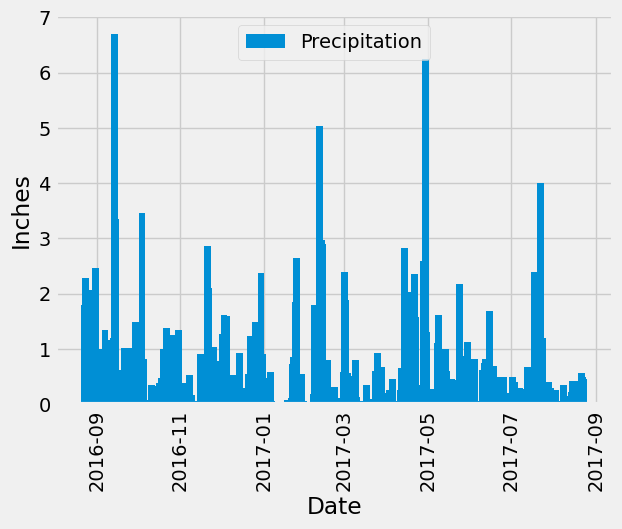

In [44]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
date = dt.date(2017, 8, 23)
# Calculate the date one year from the last date in data set.
new_date = date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
query= f"SELECT measurement.date, measurement.prcp FROM measurement WHERE measurement.date>= '{new_date}'"
prcp_scores = pd.read_sql(query,conn)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_scores_df = prcp_scores.rename(columns={'date': 'Date', 'prcp': 'Precipitation'}).dropna(how='any')

# Sort the dataframe by date
prcp_scores_df['Date'] = pd.to_datetime(prcp_scores_df['Date'])
prcp_scores_df_sorted = prcp_scores_df.sort_values(('Date'),ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
x_axis = prcp_scores_df_sorted['Date']
y_axis = prcp_scores_df_sorted['Precipitation']

plt.bar(x_axis,y_axis, alpha=1, align='center', label='Precipitation', width=5)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(loc='upper center')
plt.xticks(rotation = 'vertical')

plt.show()

In [34]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_scores_df_sorted.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [36]:
# Design a query to calculate the total number of stations in the dataset
station_query = session.query(func.count(station.station)).all()
station_query

[(9,)]

In [37]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
from sqlalchemy import func
station_groupby = session.query(measurement.station, func.count(measurement.station)).\
                group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
station_groupby

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [40]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp_USC00519281 = session.query(measurement.station, func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
                    filter(measurement.station == 'USC00519281').group_by(measurement.station).all()
temp_USC00519281

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

Text(0.5, 0, 'Temperature')

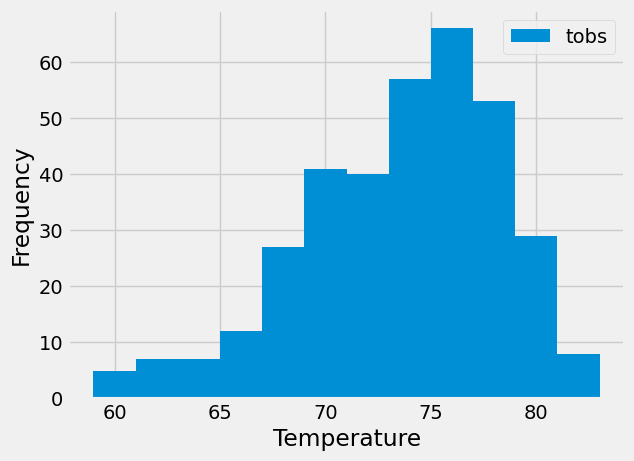

In [41]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_USC00519281 = session.query(measurement.station, measurement.tobs).\
                    filter(measurement.station == 'USC00519281').\
                    filter(measurement.date >= new_date).\
                    group_by(measurement.date).all()
temp_USC00519281_df = pd.DataFrame(temp_USC00519281)
temp_USC00519281_df.plot.hist(bins=12)
plt.xlabel('Temperature')

# Close Session

In [42]:
# Close Session
session.close()